In [1]:
# setup environment in google colab
# !pip install transformers
# !pip uninstall tensorflow
# !pip install tensorflow-gpu==2.0.0

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from transformers import TFBertForSequenceClassification, BertTokenizer
import tensorflow as tf
from tensorflow import keras

下载预训练的权重

In [2]:
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')

# 从本地文件夹中读取
# model = TFBertForSequenceClassification.from_pretrained('bert-base-chinese')

In [3]:
# data = pd.concat([
#   pd.read_csv('http://raw.githubusercontent.com/SophonPlus/ChineseNlpCorpus/master/datasets/waimai_10k/waimai_10k.csv'),                  
#   pd.read_csv('http://raw.githubusercontent.com/SophonPlus/ChineseNlpCorpus/master/datasets/ChnSentiCorp_htl_all/ChnSentiCorp_htl_all.csv')
# ], axis=0)


data = pd.read_csv('/Users/Max/Downloads/waimai_10k.csv')

# 选句子不是特别短的
data = data[data.review.str.len().between(10, 50)]

data.shape

(8811, 2)

In [4]:
# 数据预处理: (tokenize)
X, y = [], []
max_length = 100

for label, text in zip(data['label'], data['review']):
    try:
        X.append(tokenizer.encode(text, max_length=20))
        y.append(label)
    except:
        pass
    
X = tf.ragged.constant(X)
X = X.to_tensor()
y = np.array(y)

In [5]:
X.shape, y.shape

(TensorShape([8811, 20]), (8811,))

In [6]:
# 准备训练和测试的dataset
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X.numpy(), y, train_size=0.9, stratify=y, random_state=1024)
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset.batch(64)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

<BatchDataset shapes: ((None, 20), (None, 2)), types: (tf.int32, tf.float32)>

In [7]:
# 在finetune之前看看模型的表现如何
from sklearn.metrics import roc_auc_score, precision_score, classification_report

# 先跑个测试看看效果
pred_before_train = model.predict(X_test)
roc_auc_score(y_test[:, 1], pred_before_train[:, 1])

NameError: name 'model' is not defined

In [0]:
from tensorflow import keras

for layer in model.layers[:-1]:
    layer.trainable = False
# 只训练最后一个线性连接层
model.layers[-1].trainable = True

model.compile(optimizer=keras.optimizers.Adam(),
             loss=keras.losses.CategoricalCrossentropy())

In [0]:
# A custom callback that downloads all the checkpoints
from google.colab import files

class DownloadCallback(callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    checkpoint_path = './weights.{epoch:02d}.hdf5'.format(epoch=epoch+1)
    files.download(checkpoint_path)
    print('Checkpoint downloading...')
    

In [0]:
from tensorflow.keras import callbacks

lst_callback = [
    callbacks.ModelCheckpoint('./weights.{epoch:02d}.hdf5'),
    callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    # DownloadCallback()
]


In [8]:
# model.fit(X_train, y_train, epochs=20, 
#           validation_data=(X_test, y_test), callbacks=lst_callback)

In [9]:
from transformers import BertConfig

bert_config = BertConfig.from_json_file('./bert/config.json')

# 实际做预测
model = TFBertForSequenceClassification(bert_config)

# Call the model once so it gets build with the right shape before loading the weights
model((np.random.random((1, 100)) * 50).astype(int))
model.load_weights('../models/sentiment_analysis.hdf5')

(<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.27860975, 0.26705775]], dtype=float32)>,)

In [61]:
def score(sent: str):
    encoded = tokenizer.encode(sent, max_length=20, add_special_tokens=True)
    inference = keras.preprocessing.sequence.pad_sequences([encoded], maxlen=20, padding='post')
    inference = np.array(inference)

    pred = model.predict(inference)[0]
#     return pred
    return np.exp(pred)[1] / np.exp(pred).sum()

In [65]:
score('这家店的炒面非常的难吃')

0.34218708

In [29]:
pred_train = model.predict(X_train)

In [30]:
pred_train.shape

(7929, 2)

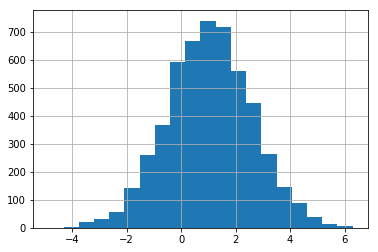

In [51]:
%matplotlib inline
pd.Series(pred_train[y_train[:, 1] == 0][:, 1] - pred_train[y_train[:, 1] == 0][:, 0]).hist(bins=20)

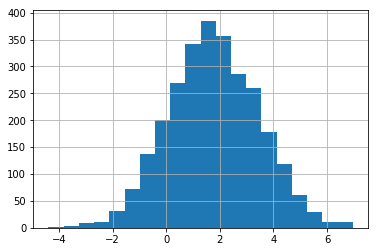

In [52]:
pd.Series(pred_train[y_train[:, 1] == 1][:, 1] - pred_train[y_train[:, 1] == 1][:, 0]).hist(bins=20)